In [2]:
# Standard libraries
import os
import math
import time

# Data manipulation and analysis
import numpy as np
import pandas as pd

#Data Visualization
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta


In [4]:
# load the dataset
df = pd.read_parquet('scale_1026', engine='auto')
df

,time,numeric_val
time,,
2019-10-24 16:35:30,2019-10-24 16:35:30,0.000000
2019-10-24 16:35:35,2019-10-24 16:35:35,47.340500
2019-10-24 16:35:40,2019-10-24 16:35:40,39.922100
2019-10-24 16:35:45,2019-10-24 16:35:45,38.546799
2019-10-24 16:35:50,2019-10-24 16:35:50,36.067299
...,...,...
2023-12-06 23:59:38,2023-12-06 23:59:38,44.203300
2023-12-06 23:59:43,2023-12-06 23:59:43,29.814301
2023-12-06 23:59:48,2023-12-06 23:59:48,52.385700


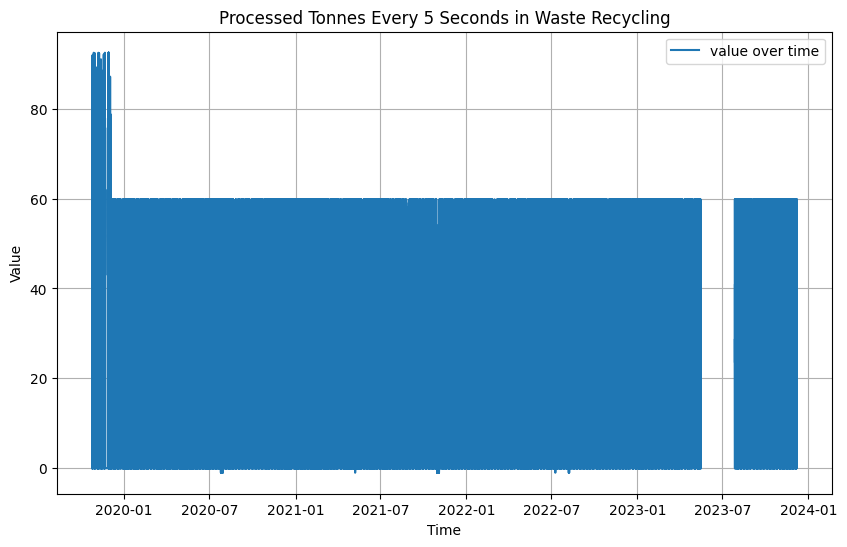

In [5]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['numeric_val'], label='value over time')


# Customize the plot
plt.title('Processed Tonnes Every 5 Seconds in Waste Recycling')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

#save
plt.savefig('precess tonnes', dpi=100, bbox_inches='tight')

# Show the plot
plt.show()

                                   time  numeric_val
time                                                
2019-10-25 06:22:18 2019-10-25 06:22:18          0.0
2019-10-25 06:22:23 2019-10-25 06:22:23          0.0
2019-10-25 06:22:28 2019-10-25 06:22:28          0.0
2019-10-25 06:22:30 2019-10-25 06:22:30          0.0
2019-10-25 06:22:33 2019-10-25 06:22:33          0.0
...                                 ...          ...
2019-10-25 11:19:04 2019-10-25 11:19:04          0.0
2019-10-25 11:19:09 2019-10-25 11:19:09          0.0
2019-10-25 11:19:14 2019-10-25 11:19:14          0.0
2019-10-25 11:19:20 2019-10-25 11:19:20          0.0
2019-10-25 11:19:25 2019-10-25 11:19:25          0.0

[3600 rows x 2 columns]


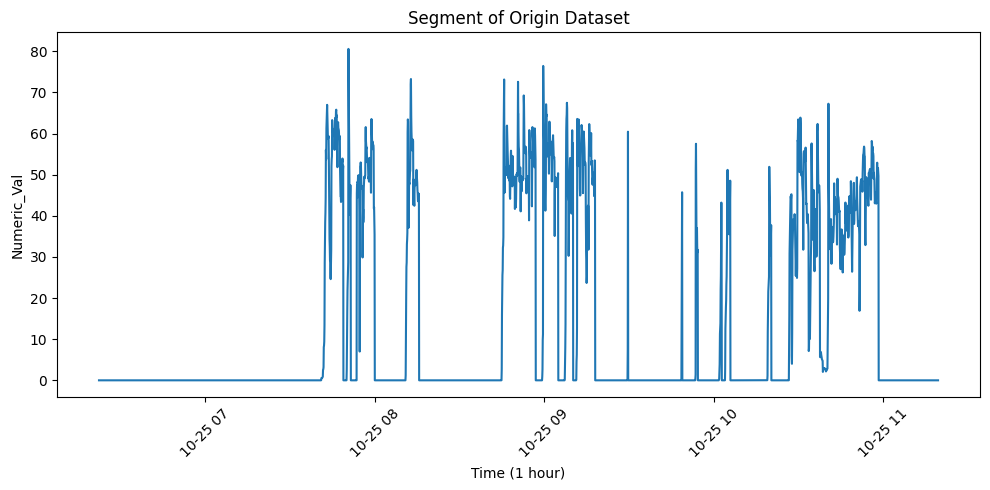

In [6]:
# Define the start and end of the segment you want to plot
start_index =10000  # starting position in the dataset
end_index = start_index + 3600 # plot 36,00 data points from the starting position

# Select the segment of data
data_segment = df.iloc[start_index:end_index]
print(data_segment)

# Plotting the selected segment
plt.figure(figsize=(10, 5))

# Specify the column to plot 
plt.plot(data_segment["time"], data_segment["numeric_val"]) 
plt.xlabel('Time (1 hour)')
plt.ylabel('Numeric_Val')
plt.title('Segment of Origin Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() 
plt.savefig('original')
plt.show()


### Data preprocessing steps:

In [8]:
#convert time column to datetime format
df['time']= pd.to_datetime(df['time'])

#Calculate the time difference using pandas diff() function 
df['time_diff']= df['time'].diff()

#create a column as date column
df['date']= df['time'].dt.date

# create a column for seconds 
df['time_sec']= df['time_diff'].dt.seconds

# then shifteing time_sec column one row up
df['time_sec'] = df['time_sec'].shift(-1)

# convert time_seconds to hour as numeric_val is tons per hour
df['time_hour']=df['time_sec']/(60*60)

df = df[["date", "numeric_val", "time_hour"]]

# calculating weighted sum
df=df.assign(weighted_sum=df.numeric_val*df.time_hour).groupby('date',as_index=False).weighted_sum.sum()
print(df)


# Make the 'date' column as index of the DataFrame
df.index = df["date"].values

df.index = pd.to_datetime(df.index)

df.drop(columns='date', inplace=True)

# Reindexing DataFrame with pd.date_range, ensure df spans a specified period, filling in any gaps with NaN values.
idx = pd.date_range('2019-10-24', '2023-12-06')

df = df.reindex(idx)

# filter out the specified data range contaning zero
df=df.drop(df.loc['2023-05-12':'2023-07-27'].index)

# Filter out the initial date range considering machine unstability
df=df.drop(df.loc['2019-10-24':'2020-01-31'].index)


rows_to_fill = np.where(df["weighted_sum"].isna())

for row in rows_to_fill:

    df.iloc[row] = df.iloc[row + 7]

# Replace negative values with zero in 'weighted_sum'
df['weighted_sum'] = df['weighted_sum'].clip(lower=0)

# replace 7 irregular data points with 8th highest value.
df[df['weighted_sum']>570]=570

print(df)
df.describe()

            date  weighted_sum
0     2019-10-24    129.124763
1     2019-10-25    397.525094
2     2019-10-26    179.953536
3     2019-10-27     19.276294
4     2019-10-28    614.867925
...          ...           ...
1486  2023-12-02    114.049422
1487  2023-12-03      0.000000
1488  2023-12-04    226.893157
1489  2023-12-05    390.659238
1490  2023-12-06    425.322937

[1491 rows x 2 columns]
            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2023-12-02    114.049422
2023-12-03      0.000000
2023-12-04    226.893157
2023-12-05    390.659238
2023-12-06    425.322937

[1328 rows x 1 columns]


,weighted_sum
count,1328.000000
mean,294.511578
std,164.458734
min,0.000000
25%,149.168497
50%,356.291042
75%,428.762568
max,570.000000


### Data Visualization after preprocessing

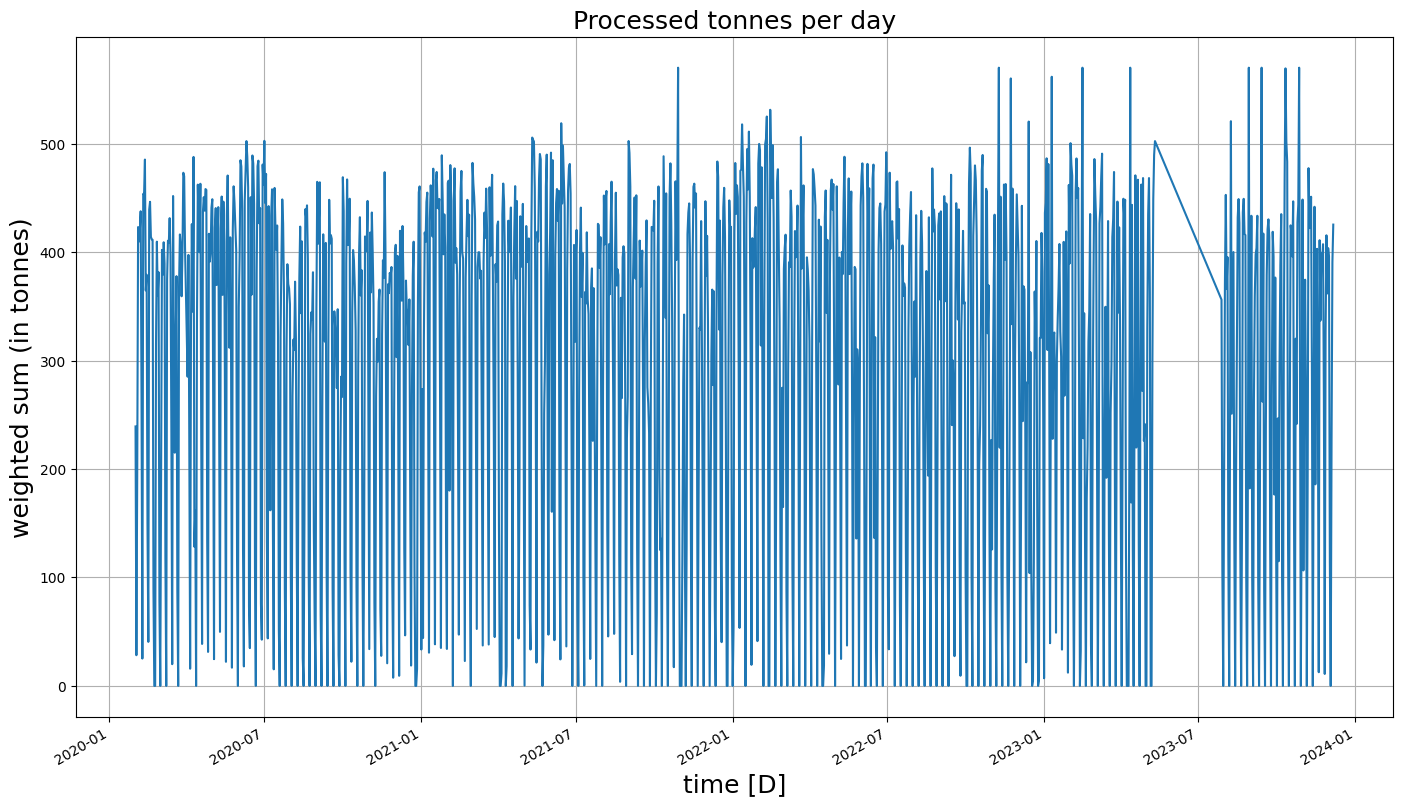

In [30]:
def plot_ts(df, xlabel='time [D]', ylabel='weighted sum (in tonnes)', title='Processed tonnes per day', figsize=(17, 10), grid=True,  title_fontsize=18):
    plt.figure()
    df['weighted_sum'].plot(xlabel=xlabel, ylabel=ylabel, title=title,  figsize=figsize, grid=grid)
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=title_fontsize)  # Set x-axis label font size
    plt.ylabel(ylabel, fontsize=title_fontsize)
    plt.savefig('Visualization')
    plt.show()
    # Visualise the initial data
plot_ts(df)